In [1]:
#### conda env Weather_Prediction

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import shap
import os
import seaborn as sns
import geopandas as gpd
pd.set_option('display.precision', 15)
pd.set_option('display.max_columns', None)

C:\Users\Shisir\.conda\envs\Weather_Prediction_Env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## year to plot and estimate
select_year=2003
year=str(select_year)
PATH_3=os.path.join('..','Results','CAMS_with_LE', 'LE_'+year +'.csv') ## read the life expectancy data
le=pd.read_csv(PATH_3)
le

,location_name,fips,year,MeanLifeExpectency
0,Autauga County (Alabama),1001,2003,74.628765329999993
1,Baldwin County (Alabama),1003,2003,76.661419230000007
2,Barbour County (Alabama),1005,2003,74.047810630000001
3,Bibb County (Alabama),1007,2003,73.057987400000002
4,Blount County (Alabama),1009,2003,75.053119350000003
...,...,...,...,...
3122,Sweetwater County (Wyoming),56037,2003,76.282640220000005
3123,Teton County (Wyoming),56039,2003,82.121084229999994
3124,Uinta County (Wyoming),56041,2003,76.259355200000002
3125,Washakie County (Wyoming),56043,2003,77.543467289999995


In [3]:
## load the county shapefile


if select_year==2003:
        
    SHAPE_PATH=os.path.join('..','Shapefiles','county_shapefiles','2008_county_shapefile',
                        'tl_2008_us_county.shp')
    county_gdf = gpd.read_file(SHAPE_PATH)
    county_gdf['fips']=county_gdf['STATEFP'] + county_gdf['COUNTYFP']
    county_gdf.dtypes
    ## convert the data type
    county_gdf['fips']=county_gdf['fips'].astype(str).astype(int)
    
elif select_year==2019:

    SHAPE_PATH=os.path.join('..','Shapefiles','county_shapefiles','2019_county_shapefile',
                        'cb_2019_us_county_500k.shp')
    county_gdf = gpd.read_file(SHAPE_PATH)
    county_gdf['fips']=county_gdf['STATEFP'] + county_gdf['COUNTYFP']
    county_gdf.dtypes
        ## convert the data type
    county_gdf['fips']=county_gdf['fips'].astype(str).astype(int)

else:
    print('no year exist')

In [4]:
county_gdf

,STATEFP,COUNTYFP,COUNTYNS,CNTYIDFP,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,geometry,fips
0,19,175,00465276,19175,Union,Union County,06,H1,G4020,None,None,None,A,"POLYGON ((-94.47051 40.97504, -94.47050 40.975...",19175
1,19,177,00465277,19177,Van Buren,Van Buren County,06,H1,G4020,None,None,None,A,"POLYGON ((-91.96059 40.90070, -91.95925 40.900...",19177
2,20,097,00485013,20097,Kiowa,Kiowa County,06,H1,G4020,None,None,None,A,"POLYGON ((-99.01471 37.67895, -99.01473 37.678...",20097
3,20,109,00485019,20109,Logan,Logan County,06,H1,G4020,None,None,None,A,"POLYGON ((-100.89562 39.13329, -100.89404 39.1...",20109
4,20,003,00484971,20003,Anderson,Anderson County,06,H1,G4020,None,None,None,A,"POLYGON ((-95.51741 38.20619, -95.51741 38.206...",20003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,35,015,00936829,35015,Eddy,Eddy County,06,H1,G4020,None,16100,None,A,"POLYGON ((-104.09554 32.00000, -104.09586 32.0...",35015
3229,40,015,01101795,40015,Caddo,Caddo County,06,H1,G4020,None,None,None,A,"POLYGON ((-98.36984 35.55133, -98.36964 35.551...",40015
3230,40,025,01101800,40025,Cimarron,Cimarron County,06,H1,G4020,None,None,None,A,"POLYGON ((-102.14252 36.50032, -102.14380 36.5...",40025
3231,40,069,01101822,40069,Johnston,Johnston County,06,H1,G4020,None,None,None,A,"POLYGON ((-96.74415 34.17223, -96.74416 34.172...",40069


In [5]:
## convert dtype to int

county_gdf['STATEFP']=county_gdf['STATEFP'].astype(str).astype(int) 
county_gdf.dtypes

county_gdf=county_gdf.loc[:,['STATEFP','geometry','fips']]
county_gdf.dtypes

STATEFP        int32
geometry    geometry
fips           int32
dtype: object

In [6]:
county_gdf

,STATEFP,geometry,fips
0,19,"POLYGON ((-94.47051 40.97504, -94.47050 40.975...",19175
1,19,"POLYGON ((-91.96059 40.90070, -91.95925 40.900...",19177
2,20,"POLYGON ((-99.01471 37.67895, -99.01473 37.678...",20097
3,20,"POLYGON ((-100.89562 39.13329, -100.89404 39.1...",20109
4,20,"POLYGON ((-95.51741 38.20619, -95.51741 38.206...",20003
...,...,...,...
3228,35,"POLYGON ((-104.09554 32.00000, -104.09586 32.0...",35015
3229,40,"POLYGON ((-98.36984 35.55133, -98.36964 35.551...",40015
3230,40,"POLYGON ((-102.14252 36.50032, -102.14380 36.5...",40025
3231,40,"POLYGON ((-96.74415 34.17223, -96.74416 34.172...",40069


In [7]:
## load state shapefile

SHAPE_PATH = os.path.join('..','Shapefiles','state_shapefile','cb_2018_us_state_500k.shp')
state_shape = gpd.read_file(SHAPE_PATH)

print('The CRS of the SHAPE file is:', state_shape.crs)

## include only contiguous shapefile

remove_state = ['Alaska', 'District of Columbia', 'American Samoa', 'United States Virgin Islands', 'Hawaii', 'Guam', 
                  'Commonwealth of the Northern Mariana Islands', 'Puerto Rico' ]

# Remove rows where the 'NAME' column contains any value from strings
state_shape = state_shape[~state_shape['NAME'].isin(remove_state)]
state_shape

The CRS of the SHAPE file is: EPSG:4269


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."
5,22,01629543,0400000US22,22,LA,Louisiana,00,111897594374,23753621895,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ..."
6,26,01779789,0400000US26,26,MI,Michigan,00,146600952990,103885855702,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ..."
7,25,00606926,0400000US25,25,MA,Massachusetts,00,20205125364,7129925486,"MULTIPOLYGON (((-70.23405 41.28565, -70.22361 ..."
8,16,01779783,0400000US16,16,ID,Idaho,00,214049787659,2391722557,"POLYGON ((-117.24267 44.39655, -117.23484 44.3..."
9,12,00294478,0400000US12,12,FL,Florida,00,138949136250,31361101223,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ..."


In [8]:
## convert dtype to int

state_shape['STATEFP']=state_shape['STATEFP'].astype(str).astype(int) 
state_shape=state_shape.loc[:,['STATEFP','geometry']]
state_shape.dtypes

STATEFP        int32
geometry    geometry
dtype: object

In [9]:
state_shape_to_merge=state_shape.rename(columns={'geometry':'state_geometry'})
state_shape_to_merge

,STATEFP,state_geometry
0,28,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."
5,22,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ..."
6,26,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ..."
7,25,"MULTIPOLYGON (((-70.23405 41.28565, -70.22361 ..."
8,16,"POLYGON ((-117.24267 44.39655, -117.23484 44.3..."
9,12,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ..."


In [10]:
gpd_df_initial = pd.merge(county_gdf, state_shape_to_merge, on='STATEFP', how='left') 
gpd_df_initial
gpd_df_initial=gpd_df_initial.dropna()
gpd_df_initial
## It is VERY IMPORTANT that the left dataframe that is merged is a Geopandas Dataframe
## Not pandas dataframe. While a Geopandas dataframe can be easily plotted, a pandas  
## even if it consists Geometry column, geopandas will not recognize it and it will not be plotted

,STATEFP,geometry,fips,state_geometry
0,19,"POLYGON ((-94.47051 40.97504, -94.47050 40.975...",19175,"POLYGON ((-96.63970 42.73707, -96.63589 42.741..."
1,19,"POLYGON ((-91.96059 40.90070, -91.95925 40.900...",19177,"POLYGON ((-96.63970 42.73707, -96.63589 42.741..."
2,20,"POLYGON ((-99.01471 37.67895, -99.01473 37.678...",20097,"POLYGON ((-102.05174 40.00308, -101.91670 40.0..."
3,20,"POLYGON ((-100.89562 39.13329, -100.89404 39.1...",20109,"POLYGON ((-102.05174 40.00308, -101.91670 40.0..."
4,20,"POLYGON ((-95.51741 38.20619, -95.51741 38.206...",20003,"POLYGON ((-102.05174 40.00308, -101.91670 40.0..."
...,...,...,...,...
3228,35,"POLYGON ((-104.09554 32.00000, -104.09586 32.0...",35015,"POLYGON ((-109.05017 31.48000, -109.04984 31.4..."
3229,40,"POLYGON ((-98.36984 35.55133, -98.36964 35.551...",40015,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3230,40,"POLYGON ((-102.14252 36.50032, -102.14380 36.5...",40025,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3231,40,"POLYGON ((-96.74415 34.17223, -96.74416 34.172...",40069,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."


In [11]:
gpd_df_initial = gpd_df_initial.drop('state_geometry', axis=1)
gpd_df_initial

,STATEFP,geometry,fips
0,19,"POLYGON ((-94.47051 40.97504, -94.47050 40.975...",19175
1,19,"POLYGON ((-91.96059 40.90070, -91.95925 40.900...",19177
2,20,"POLYGON ((-99.01471 37.67895, -99.01473 37.678...",20097
3,20,"POLYGON ((-100.89562 39.13329, -100.89404 39.1...",20109
4,20,"POLYGON ((-95.51741 38.20619, -95.51741 38.206...",20003
...,...,...,...
3228,35,"POLYGON ((-104.09554 32.00000, -104.09586 32.0...",35015
3229,40,"POLYGON ((-98.36984 35.55133, -98.36964 35.551...",40015
3230,40,"POLYGON ((-102.14252 36.50032, -102.14380 36.5...",40025
3231,40,"POLYGON ((-96.74415 34.17223, -96.74416 34.172...",40069


In [12]:
gpd_df = pd.merge(gpd_df_initial, le, on='fips', how='left') ## merge dataframes to plot
gpd_df= gpd_df.dropna()
gpd_df 

,STATEFP,geometry,fips,location_name,year,MeanLifeExpectency
0,19,"POLYGON ((-94.47051 40.97504, -94.47050 40.975...",19175,Union County (Iowa),2003.0,77.394023340000004
1,19,"POLYGON ((-91.96059 40.90070, -91.95925 40.900...",19177,Van Buren County (Iowa),2003.0,77.479657250000002
2,20,"POLYGON ((-99.01471 37.67895, -99.01473 37.678...",20097,Kiowa County (Kansas),2003.0,78.476606509999996
3,20,"POLYGON ((-100.89562 39.13329, -100.89404 39.1...",20109,Logan County (Kansas),2003.0,77.680070729999997
4,20,"POLYGON ((-95.51741 38.20619, -95.51741 38.206...",20003,Anderson County (Kansas),2003.0,77.304935709999995
...,...,...,...,...,...,...
3103,35,"POLYGON ((-104.09554 32.00000, -104.09586 32.0...",35015,Eddy County (New Mexico),2003.0,75.094770949999997
3104,40,"POLYGON ((-98.36984 35.55133, -98.36964 35.551...",40015,Caddo County (Oklahoma),2003.0,72.692495210000004
3105,40,"POLYGON ((-102.14252 36.50032, -102.14380 36.5...",40025,Cimarron County (Oklahoma),2003.0,75.605538650000000
3106,40,"POLYGON ((-96.74415 34.17223, -96.74416 34.172...",40069,Johnston County (Oklahoma),2003.0,72.608984890000002


<Axes: >

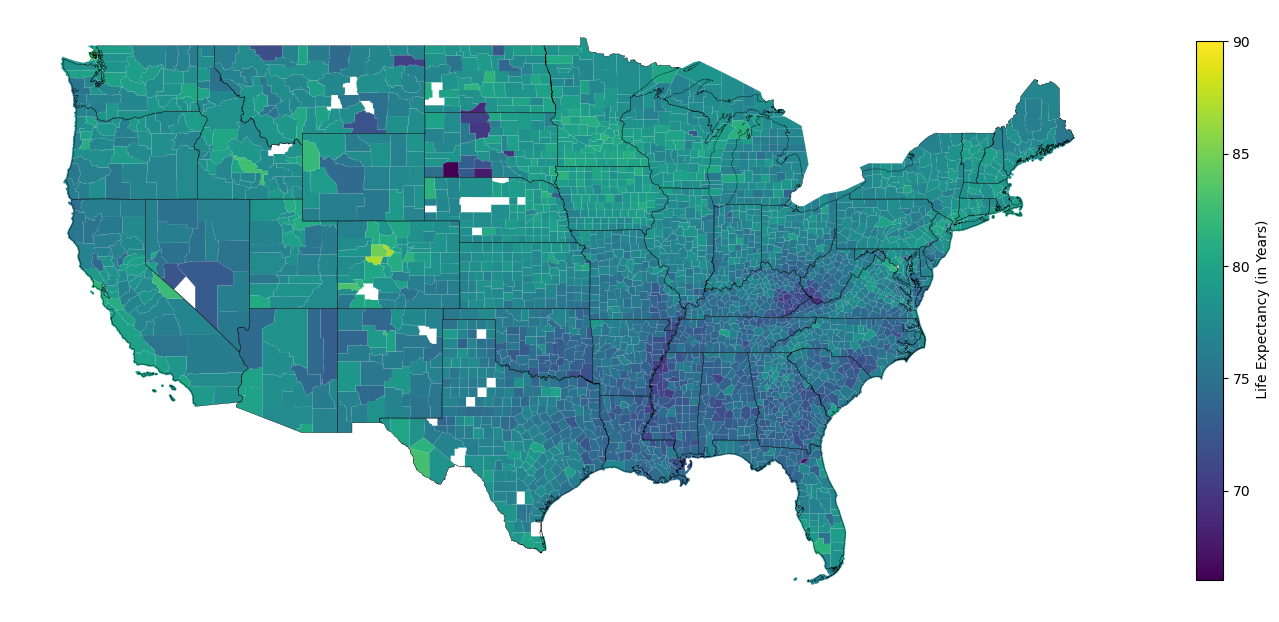

In [14]:
## plot the county shape file
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 

gpd_df.plot(ax=ax,column='MeanLifeExpectency', legend=True, legend_kwds={"label": " Life Expectancy (in Years)", 
                                                                               "shrink":0.50}, vmin=66, vmax=90)

## overlay state shapefile

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)